In [14]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf
from vit_pytorch import ViT
import transforms3d.quaternions as tfq

In [19]:
mc = 350 # 345 is max dim, of binned event image
bins = 1
delta = 10 # corresponding to running loc at 10Hz

class EventDataset(Dataset):
    def __init__(self, data_dir, label_delta_len):
        imu_cols=["timestamp", "ang_vel_x", "ang_vel_y", "ang_vel_z", "lin_acc_x", "lin_acc_y", "lin_acc_z"]
        self.imu_df = pd.read_csv(os.path.join(data_dir,"imu.txt"), delimiter=' ', skiprows=1, names=imu_cols)
        self.imu_df.index = pd.to_datetime(self.imu_df["timestamp"], unit='s')
        imu_df_nostamp = self.imu_df.loc[:, self.imu_df.columns != 'timestamp']
        self.imu_data = imu_df_nostamp.to_numpy(dtype=np.float32)
        self.imu_data = torch.from_numpy(self.imu_data)

        events_cols=["timestamp", "x", "y", "polarity"]
        events_df = pd.read_csv(os.path.join(data_dir,"events.txt"), delimiter=' ', skiprows=1, names=events_cols)
        events_df_nostamp = events_df.loc[:, events_df.columns != 'timestamp']
        self.events_data = torch.from_numpy(events_df_nostamp.to_numpy(dtype=np.float32)).type(torch.LongTensor)

        indexed_labels_pickle = f"data/event_indexed_labels_{delta}.pickle"
        if os.path.isfile(indexed_labels_pickle):
            self.labels_df = pd.read_pickle(indexed_labels_pickle)
            self.labels_df["timestamp"] = pd.to_datetime(self.labels_df["timestamp"], unit='s')
        else:
            label_cols = ["timestamp","tx","ty","tz","qx","qy","qz","qw","none"]
            labels_df = pd.read_csv(os.path.join(data_dir,"groundtruth.txt"), delimiter=' ', skiprows=1, names=label_cols)
            labels_df = labels_df.iloc[: , :-1]
            # rearange quaternion, w goes first
            columns_titles = ["timestamp","tx","ty","tz","qw","qx","qy","qz"]
            labels_df = labels_df.reindex(columns=columns_titles)
            labels_df["events_start_idx"] = 0
            self.labels_df = labels_df
            labels_df_nostamp = labels_df.loc[:, labels_df.columns != 'timestamp']
            labels_df_nostamp = labels_df_nostamp.loc[:, labels_df_nostamp.columns != 'events_start_idx']
            labels = labels_df_nostamp.to_numpy()

            q0 = labels[0,3:] # take first one and align everything to it
            q0inv = tfq.qinverse(q0)
            # q0, q0inv, tfq.qmult(q0,q0inv), tfq.nearly_equivalent(tfq.qmult(q0,q0inv),tfq.qeye())

            new_cols = ["dtx","dty","dtz","dqw","dqx","dqy","dqz"]
            for col in new_cols:
                self.labels_df[col] = 0.0
            first_id = abs(events_df["timestamp"]-self.labels_df.iloc[0]["timestamp"]).idxmin()
            for i in range(len(self.labels_df)-delta):
                label_ts = self.labels_df.iloc[i,0]
                # hopefully no more than 10k event between labels
                id = events_df[first_id:first_id+int(1e4)]["timestamp"].sub(label_ts).abs().idxmin()
                self.labels_df["events_start_idx"][i] = id
                first_id = id
                if i % 1000 == 0:
                    print(i)

                dpose = np.zeros(7, dtype=np.float64)
                l1 = labels[i]
                l2 = labels[i+delta]
                dl = tfq.rotate_vector(l2[:3], q0inv) - tfq.rotate_vector(l1[:3], q0inv) # position delta
                dpose[:3] = dl
                q1 = tfq.qmult(l1[3:],q0inv) #[[3,0,1,2]]
                q2 = tfq.qmult(l2[3:],q0inv) #[[3,0,1,2]]
                dq = tf.quaternions.qmult(q2, tf.quaternions.qinverse(q1)) # orientation delta
                dpose[3:] = dq # pose delta is the label

                for col_index,col in enumerate(new_cols):
                    self.labels_df[col][i+delta] = dpose[col_index]
                
            # save for easy loading
            self.labels_df.to_pickle(indexed_labels_pickle)

        self.labels = torch.tensor(self.labels_df.loc[:, 'dtx':'dqz'].to_numpy(), dtype=torch.float32)
        print(f"means: {self.labels.mean()}\nstds: {self.labels.std()}")
        self.labels = (self.labels - self.labels.mean()) / self.labels.std()

        self.delta = label_delta_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        dpose = self.labels[idx+self.delta]

        start = self.labels_df.iloc[idx]["events_start_idx"]
        finish = self.labels_df.iloc[idx+self.delta]["events_start_idx"]

        if bins > 1:
            num_per_bin = int((finish-start)/bins)
            binned_events = torch.zeros((bins,mc,mc))
            for b in range(bins):
                start_bin = int(start)+b*num_per_bin
                if b != (bins - 1):
                    events = self.events_data[start_bin:start_bin+num_per_bin]
                else:
                    events = self.events_data[start_bin:int(finish)]
                binned_events[b] = torch.index_put(binned_events[b], (events[:,1], events[:,0]), (events[:,2].type(torch.FloatTensor) - .5), accumulate=True)
        else:
            binned_events = torch.zeros((bins,mc,mc))
            events = self.events_data[int(start):int(finish)]
            binned_events[0] = torch.index_put(binned_events[0], (events[:,1], events[:,0]), (events[:,2].type(torch.FloatTensor) - .5), accumulate=True)

        imu_index_start = self.imu_df.index.get_loc(self.labels_df.iloc[idx]["timestamp"], method='nearest')
        imu_index_end = self.imu_df.index.get_loc(self.labels_df.iloc[idx+self.delta]["timestamp"], method='nearest')
        imu = self.imu_data[imu_index_start:imu_index_end]

        sample = {"imu": imu, "events": events, "label": dpose}

        return sample

    def set_label_delta(self, delta):
        self.delta = delta

data_dir = "indoor_forward_9_davis_with_gt"
vio_dataset = EventDataset(data_dir, delta)
means = 0.14266261458396912
stds = 0.3516494035720825

from functools import partial
# pad_frames = partial(torch.nn.utils.rnn.pad_sequence, batch_first=True, padding_value=-1.)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=80, shuffle=True, num_workers=8)

for batch in dataloader:
    print(batch)
    break

means: 0.14081615209579468
stds: 0.35239288210868835


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 160, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 160, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 140, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [3]:
# vio_dataset.set_label_delta(delta)
# point = vio_dataset.__getitem__(3000)
# events = point[0].squeeze(0)
# for i in range(bins):
#     plt.figure(i)
#     if bins == 1:
#         plt.imshow(events)
#     else:
#         plt.imshow(events[i])
# events.max(), events.min(), events.shape, torch.norm(1 - torch.norm(point[1][3:])), point[1]

In [5]:
# import time
# s = time.time()
# for i in range(1000):
#     size = vio_dataset.__getitem__(i)[0][0].shape[0]
# (time.time() - s) / 1000 # per one sample, very quick

In [7]:
class IMUTransformer(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=6, nhead=6, dim_feedforward=32, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.encoder = transformer_encoder
        self.fc1 = nn.Linear(in_features=6, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=out_features)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = torch.relu(self.fc1(x[:,-1,:]))
        x = self.fc2(x)
        return x

class ImuEventModel(torch.nn.Module):

    def __init__(self, out_features=32):
        super(ImuEventModel, self).__init__()
        self.event_tf = ViT(
            image_size = 350,
            patch_size = 25,
            num_classes = out_features,
            dim = 32,
            depth = 6,
            heads = 8,
            mlp_dim = 64,
            dropout = 0.1,
            emb_dropout = 0.0,
            channels=bins
        )
        self.imu_tf = IMUTransformer(out_features)
        self.linear1 = torch.nn.Linear(out_features*2, out_features*2)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(out_features*2, 7)

    def forward(self, x):
        # let's say x is tuple
        events = x[0]
        imu = x[1]
        events_out = self.event_tf(events)
        imu_out = self.imu_tf (imu)
        x = torch.concat(events_out, imu_out)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

model = ImuEventModel()


In [9]:
# model = ViT(
#     image_size = 350,
#     patch_size = 25,
#     num_classes = 7,
#     dim = 32,
#     depth = 6,
#     heads = 8,
#     mlp_dim = 64,
#     dropout = 0.1,
#     emb_dropout = 0.0,
#     channels=bins
# )

# img = vio_dataset.__getitem__(1002)[0].unsqueeze(0) # batch 1
# preds = model(img) # (1, 7)
# preds

In [12]:
# model.event_tf.load_state_dict(torch.load("data/event_model.pt"))
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,30,50,70], gamma=.1)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=80, shuffle=True, num_workers=8)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    break


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 160, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 160, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 140, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [ ]:
# # ### lr search : )
# lr = .01
# gamma = .5
# [lr*gamma**x for x in range(10)]

In [ ]:
# # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

# torch.cuda.empty_cache()

# num_epochs = 100
# for epoch in range(num_epochs):
#     print(f'Epoch {epoch}/{num_epochs - 1}')
#     print('-' * 10)

#     for phase in ['train']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0

#         # Iterate over data.
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels) # + torch.norm(1 - torch.norm(outputs[3:]), 1)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)

#         epoch_loss = running_loss / len(vio_dataset)

#         print(f'{phase} Loss: {epoch_loss:.8f}')
        
#     scheduler.step()
#     if epoch % 25 == 0:
#         torch.save(model.state_dict(), "event_model.pt")

# torch.save(model.state_dict(), "event_model.pt")

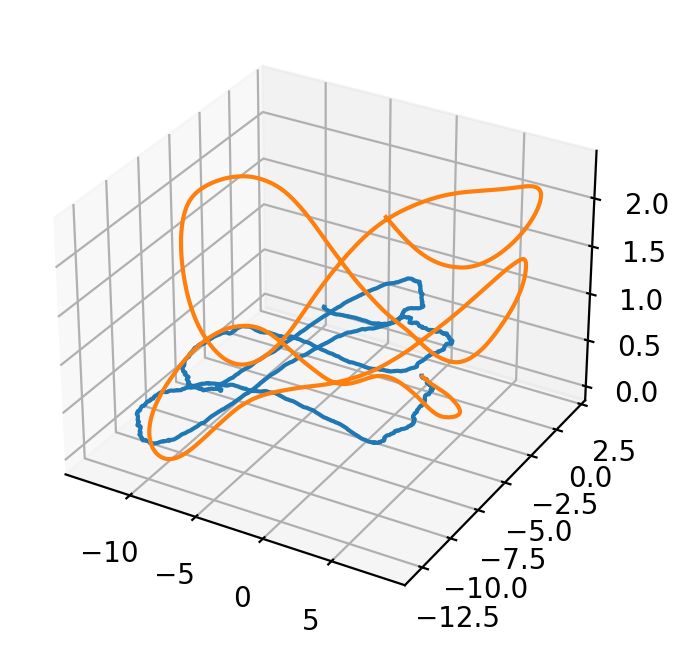

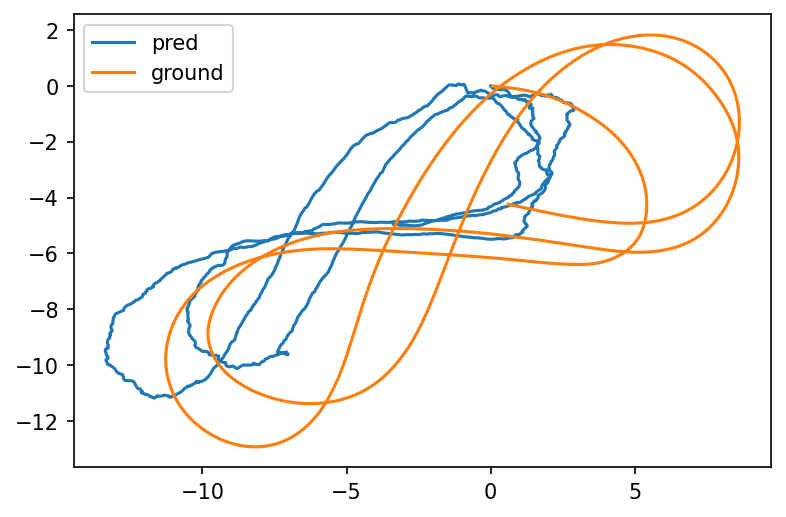

In [27]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))

q0 = vio_dataset.labels[0,3:] # revert back the labels with this

for i in range(200, int(len(vio_dataset)/delta)):
    data_point = vio_dataset.__getitem__(i*delta)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    rotated = tfq.rotate_vector((delta_label * stds + means).reshape((3,)), q0)
    gtx += rotated.reshape((3,1))
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    xpred_rot = tfq.rotate_vector((dx * stds + means).reshape((3,)), q0)
    x += xpred_rot.reshape((3,1))
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])

plt.figure(2, dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])

del path, ground, x, gtx